# Sentiment Analysis in Python

This notebook is part of a tutorial that can be found on my [youtube channel here](https://www.youtube.com/channel/UCxladMszXan-jfgzyeIMyvw), please check it out!

In this notebook we will be doing some sentiment analysis in python using two different techniques:
1. VADER (Valence Aware Dictionary and sEntiment Reasoner) - Bag of words approach
2. Roberta Pretrained Model from 🤗
3. Huggingface Pipeline

# Step 0. Read in Data and NLTK Basics

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [3]:
# Read in data
df = pd.read_csv('Reviews.csv')
print(df.shape)
#df = df.head(500)
print(df.shape)

(568454, 10)
(568454, 10)


In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Quick EDA

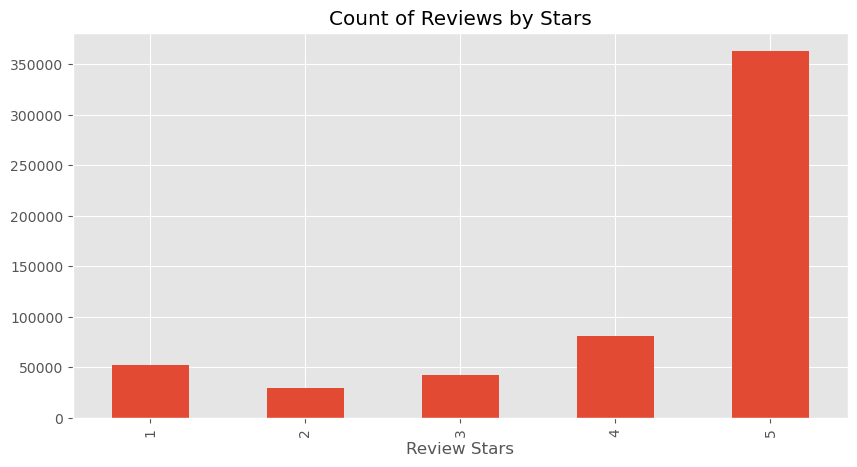

In [4]:
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

In [5]:
df['Score'].value_counts()

5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64

In [6]:
df['Score'].mean()

4.183198640523243

In [7]:
df_avg_prodscores = df[["ProductId", "Score"]].groupby("ProductId").mean().reset_index()

In [8]:
df_avg_prodscores

,ProductId,Score
0,0006641040,4.351351
1,141278509X,5.000000
2,2734888454,3.500000
3,2841233731,5.000000
4,7310172001,4.751445
...,...,...
74253,B009UOFTUI,1.000000
74254,B009UOFU20,1.000000
74255,B009UUS05I,5.000000
74256,B009WSNWC4,5.000000


<AxesSubplot:ylabel='Density'>

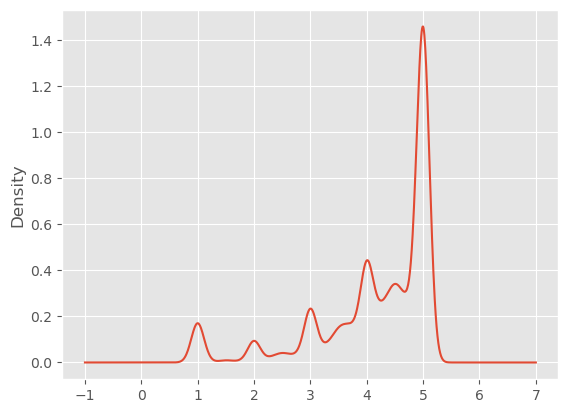

In [9]:
df_avg_prodscores['Score'].plot(kind='kde')

## Basic NLTK

In [10]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [11]:
#nltk.download()
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [12]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [13]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


# Step 1. VADER Seniment Scoring

We will use NLTK's `SentimentIntensityAnalyzer` to get the neg/neu/pos scores of the text.

- This uses a "bag of words" approach:
    1. Stop words are removed
    2. each word is scored and combined to a total score.

In [14]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [15]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [16]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [17]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [18]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/568454 [00:00<?, ?it/s]

In [19]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [20]:
# Now we have sentiment score and metadata
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [21]:
vaders[["Score", "pos"]].groupby("Score").mean().reset_index()

,Score,pos
0,1,0.096408
1,2,0.115551
2,3,0.138503
3,4,0.185277
4,5,0.220328


## Plot VADER results

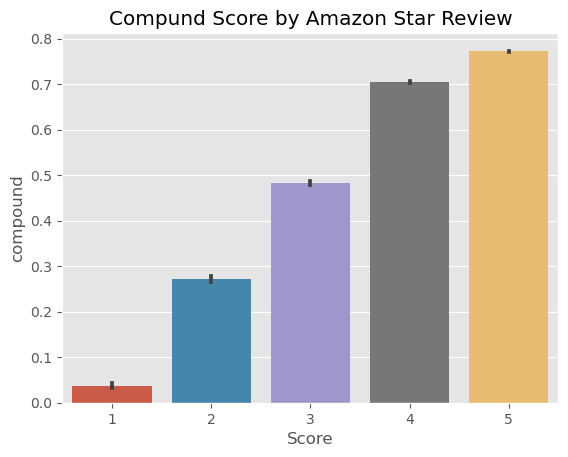

In [22]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

<AxesSubplot:xlabel='Score', ylabel='pos'>

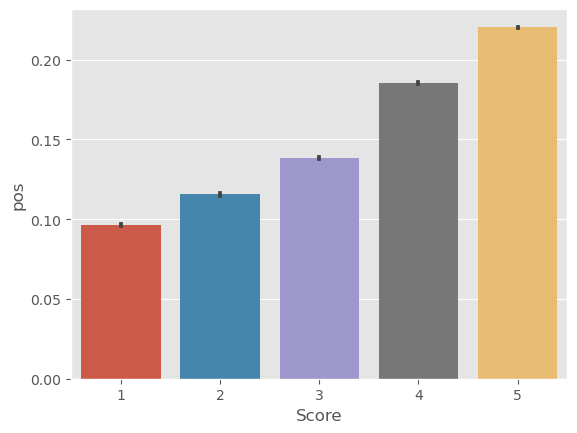

In [23]:
sns.barplot(data=vaders, x='Score', y='pos')

<AxesSubplot:xlabel='Score', ylabel='neu'>

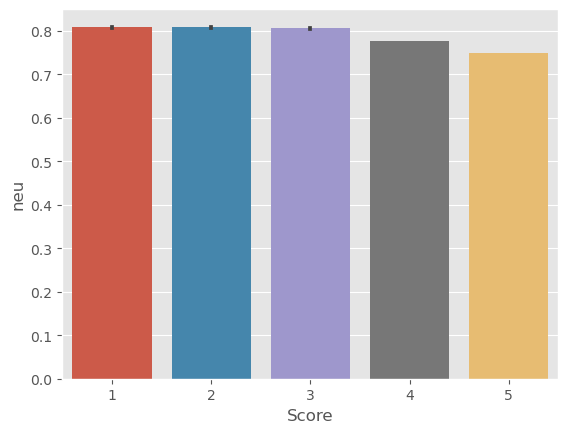

In [24]:
sns.barplot(data=vaders, x='Score', y='neu')

<AxesSubplot:xlabel='Score', ylabel='neg'>

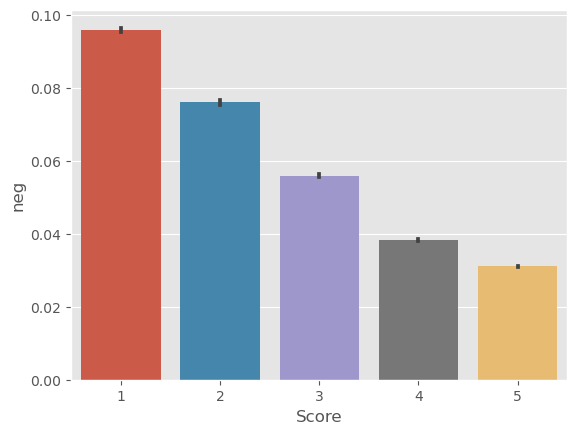

In [25]:
sns.barplot(data=vaders, x='Score', y='neg')

# Step 3. Roberta Pretrained Model

- Use a model trained of a large corpus of data.
- Transformer model accounts for the words but also the context related to other words.

In [26]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [97]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [28]:
# VADER results on example
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [29]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.97635514, 'roberta_neu': 0.020687466, 'roberta_pos': 0.0029573694}


In [30]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [32]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/568454 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187
Broke for id 529
Broke for id 540
Broke for id 746
Broke for id 863
Broke for id 1053
Broke for id 1070
Broke for id 1156
Broke for id 1321
Broke for id 1375
Broke for id 1498
Broke for id 1575
Broke for id 1796
Broke for id 1826
Broke for id 2169
Broke for id 2248
Broke for id 2476
Broke for id 2492
Broke for id 2584
Broke for id 2610
Broke for id 2897
Broke for id 2898
Broke for id 2902
Broke for id 2928
Broke for id 2942
Broke for id 2944
Broke for id 2947
Broke for id 2948
Broke for id 3022
Broke for id 3023
Broke for id 3025
Broke for id 3306
Broke for id 3788


KeyboardInterrupt: 

In [34]:
len(df)

568454

In [2]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')
# df.to_csv('filepath')

NameError: name 'res' is not defined

In [3]:
results_df = pd.read_csv('Reviews_Roberta_Vader_full.csv')

## Compare Scores between models

In [4]:
results_df.columns

Index(['Unnamed: 0', 'Id', 'vader_neg', 'vader_neu', 'vader_pos',
       'vader_compound', 'roberta_neg', 'roberta_neu', 'roberta_pos',
       'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

# Step 3. Combine and compare

KeyboardInterrupt: 

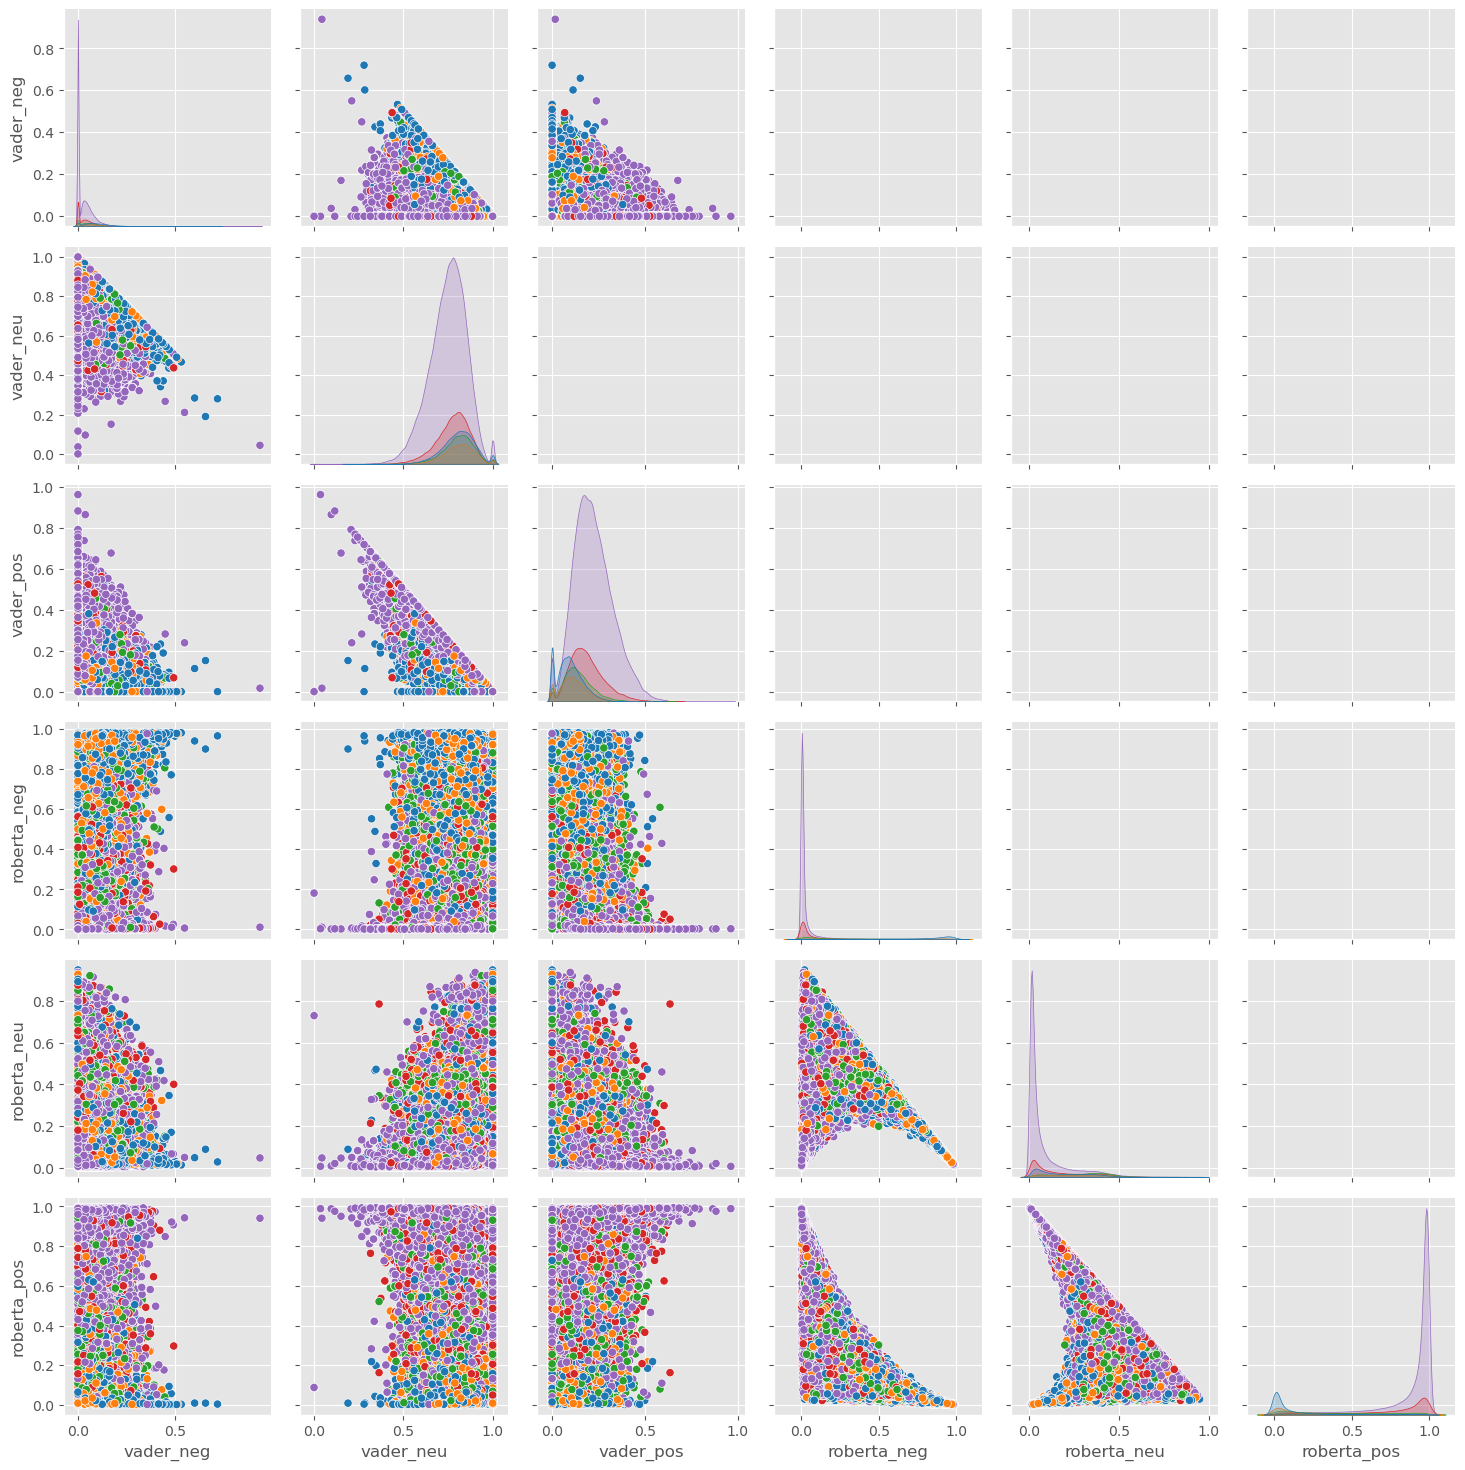

In [6]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

In [5]:
from sklearn.model_selection import train_test_split
Xv = results_df[['vader_neg','vader_neu','vader_pos']]
Xr = results_df[['roberta_neg','roberta_neu','roberta_pos']]
Y = results_df[['Score']]
X_trainv, X_testv, y_trainv, y_testv = train_test_split(Xv, Y, test_size=0.3, random_state=42)
X_trainr, X_testr, y_trainr, y_testr = train_test_split(Xr, Y, test_size=0.3, random_state=42)

In [6]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn import metrics
from sklearn.metrics import r2_score
modelv = LinearRegression()
#modelv.fit(X_trainv, y_trainv)
modelv = sm.OLS(y_trainv, X_trainv).fit()

#print(modelv.coef_)
#print(modelv.intercept_)
print(modelv.summary())
y_predv = modelv.predict(X_testv)
print(metrics.mean_squared_error(y_testv,y_predv))
print(r2_score(y_testv, y_predv))

                                 OLS Regression Results                                
Dep. Variable:                  Score   R-squared (uncentered):                   0.932
Model:                            OLS   Adj. R-squared (uncentered):              0.932
Method:                 Least Squares   F-statistic:                          1.790e+06
Date:                Tue, 25 Apr 2023   Prob (F-statistic):                        0.00
Time:                        16:38:36   Log-Likelihood:                     -6.1240e+05
No. Observations:              393714   AIC:                                  1.225e+06
Df Residuals:                  393711   BIC:                                  1.225e+06
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [7]:
modelr = LinearRegression()
#modelr.fit(X_trainr, y_trainr)
modelr = sm.OLS(y_trainr, X_trainr).fit()
#print(modelr.coef_)
#print(modelr.intercept_)
print(modelr.summary())
y_predr = modelr.predict(X_testr)
print(metrics.mean_squared_error(y_testr,y_predr))
print(r2_score(y_testr, y_predr))

                                 OLS Regression Results                                
Dep. Variable:                  Score   R-squared (uncentered):                   0.965
Model:                            OLS   Adj. R-squared (uncentered):              0.965
Method:                 Least Squares   F-statistic:                          3.633e+06
Date:                Tue, 25 Apr 2023   Prob (F-statistic):                        0.00
Time:                        16:38:36   Log-Likelihood:                     -4.8004e+05
No. Observations:              393714   AIC:                                  9.601e+05
Df Residuals:                  393711   BIC:                                  9.601e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [8]:
y_predv 

181503    4.535614
261142    3.923264
353131    4.406093
345169    3.503125
5035      4.538048
            ...   
353688    3.792951
299920    3.707365
147961    4.605007
433563    4.257278
143770    3.768014
Length: 168735, dtype: float64

In [9]:
y_testv

,Score
181503,5
261142,5
353131,5
345169,5
5035,5
...,...
353688,5
299920,5
147961,1
433563,5


In [90]:
5.1765/2.5257

2.0495308231381397

In [27]:
# Text1 = 'I absolutely loved the fajitas.'
# Text2 = 'The starters are great, but the main course is not good.'
# Text3 = 'The food here is unbelievably bad.'
Text1 = 'I absolutely loved the product!'
Text2 ='The performance of the product is great, but the battery life is bad.'
Text3 = 'The food here is unbelievably bad.'

In [28]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [29]:
sia.polarity_scores(Text1)

{'neg': 0.0, 'neu': 0.401, 'pos': 0.599, 'compound': 0.6689}

In [30]:
sia.polarity_scores(Text2)

{'neg': 0.26, 'neu': 0.601, 'pos': 0.139, 'compound': -0.4939}

In [31]:
sia.polarity_scores(Text3)

{'neg': 0.431, 'neu': 0.569, 'pos': 0.0, 'compound': -0.5849}

In [32]:
def scores(t, model, sia):
    ts  = sia.polarity_scores(t) 
    pos = ts['pos']
    neu = ts['neu']
    neg = ts['neg']
    dic = {}
    posl = [pos]
    neul = [neu]
    negl = [neg]
    dic['neg'] = negl
    dic['neu'] = neul
    dic['pos'] = posl
    #print(dic)
    X = pd.DataFrame.from_dict(dic)
    sc = model.predict(X)
    sc = sc[0]
    if sc > 5:
        sc = 5
    if sc < 1:
        sc = 1
    return sc
# print(scores(Text1, modelv, sia))
# print(scores(Text2, modelv, sia))
# print(scores(Text3, modelv, sia))



In [33]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Run for Roberta Model

def scores_r(text, model, modelr, tokenizer):
    encoded_text = tokenizer(text, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'neg' : scores[0],
        'neu' : scores[1],
        'pos' : scores[2]
    }
    dic = {}
    negl = [scores_dict['neg']]
    neul = [scores_dict['neu']]
    posl = [scores_dict['pos']]
    dic['neg'] = negl
    dic['neu'] = neul
    dic['pos'] = posl
    #print(dic)
    X = pd.DataFrame.from_dict(dic)
    sc = modelr.predict(X)
    sc = sc[0]
    if sc > 5:
        sc = 5
    if sc < 1:
        sc = 1
    return sc
    
# print(scores_r(Text1, model, modelr, tokenizer))
# print(scores_r(Text2, model, modelr, tokenizer))
# print(scores_r(Text3, model, modelr, tokenizer))

#### Decision Tree

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_roc_curve(tpr, fpr, scatter = True):
    plt.figure(figsize = (5, 5))
    if scatter:
        sns.scatterplot(x = fpr, y = tpr)
    sns.lineplot(x = fpr, y = tpr)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green')
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

In [96]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

In [111]:
df = pd.read_csv('Reviews_Roberta_Vader_full.csv')
Xv = df[['vader_neg','vader_neu','vader_pos']]
Xr = df[['roberta_neg','roberta_neu','roberta_pos']]
Y = df[['Score']]
X_trainv, X_testv, y_trainv, y_testv = train_test_split(Xv, Y, test_size=0.3, random_state=42)
X_trainr, X_testr, y_trainr, y_testr = train_test_split(Xr, Y, test_size=0.3, random_state=42)

In [112]:
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clfv = clf.fit(X_trainv,y_trainv)

#Predict the response for test dataset
y_predv = clfv.predict(X_testv)

Accuracy: 0.6656236109876433
              precision    recall  f1-score   support

           1       0.47      0.47      0.47     15498
           2       0.38      0.28      0.32      8803
           3       0.37      0.25      0.30     12517
           4       0.41      0.22      0.29     23998
           5       0.75      0.87      0.81    107919

    accuracy                           0.67    168735
   macro avg       0.48      0.42      0.44    168735
weighted avg       0.63      0.67      0.64    168735

F1 Score Macro: 0.4368170072649084
F1 Score micro: 0.6656236109876433
F1 Score weighted: 0.6388743074817704
roc_auc_score for DecisionTree for Class 1 vs Rest:  0.748706946971607


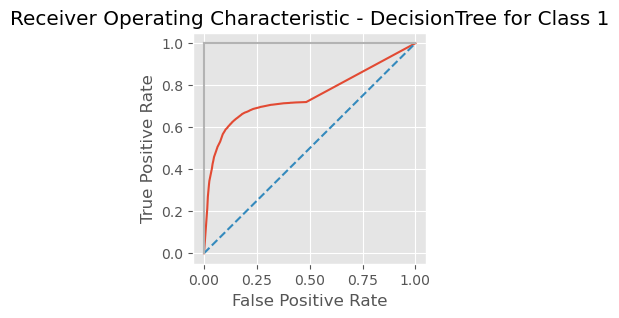

roc_auc_score for DecisionTree for Class 2 vs Rest:  0.6854163818356188


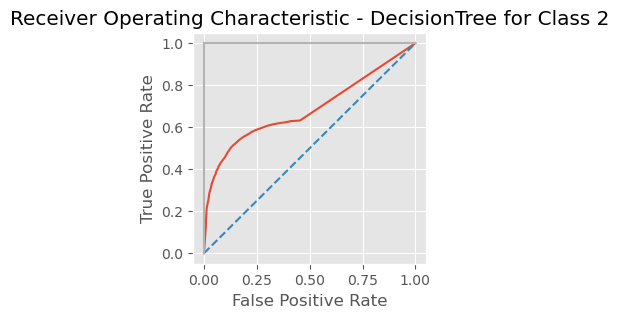

roc_auc_score for DecisionTree for Class 3 vs Rest:  0.6749664742779762


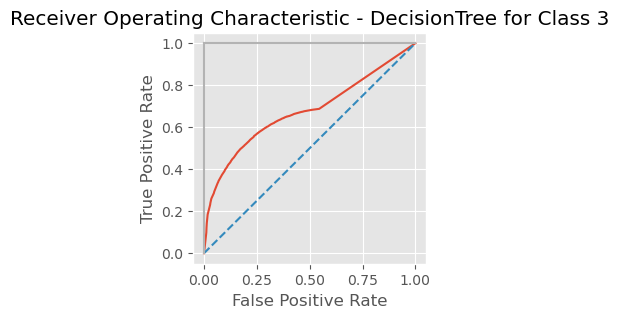

roc_auc_score for DecisionTree for Class 4 vs Rest:  0.6583598011810753


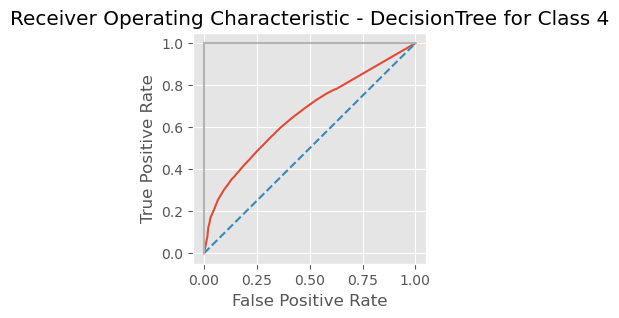

roc_auc_score for DecisionTree for Class 4 vs Rest:  0.7428659987632767


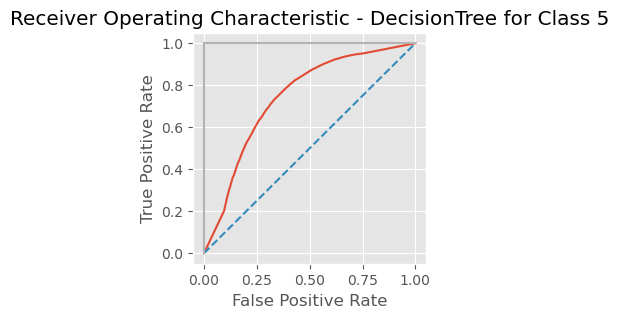

In [153]:
print("Accuracy:",accuracy_score(y_testv, y_predv))
from sklearn.metrics import classification_report
y_true = [0, 1, 2, 2, 2]
y_pred = [0, 0, 2, 2, 1]
target_names = [ '1', '2', '3','4','5']
print(classification_report(y_testv, y_predv, target_names=target_names))

from sklearn.metrics import f1_score
print("F1 Score Macro:",f1_score(y_testv, y_predv, average='macro'))
print("F1 Score micro:",f1_score(y_testv, y_predv, average='micro'))
print("F1 Score weighted:",f1_score(y_testv, y_predv, average='weighted'))

#print(y_testv)
from sklearn.metrics import roc_curve, roc_auc_score
y_testv1 = np.array(y_testv["Score"])
y_testv1 = [1 if y == 1 else 0 for y in y_testv1]
y_scorev1 = clfv.predict_proba(X_testv)[:,0]                 
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_testv1, y_scorev1)
print('roc_auc_score for DecisionTree for Class 1 vs Rest: ', roc_auc_score(y_testv1, y_scorev1))

plt.subplots(1, figsize=(3,3))
plt.title('Receiver Operating Characteristic - DecisionTree for Class 1')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##############################################END##################################################
y_testv2 = np.array(y_testv["Score"])
y_testv2 = [1 if y == 2 else 0 for y in y_testv2]
y_scorev2 = clfv.predict_proba(X_testv)[:,1]                 
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_testv2, y_scorev2)
print('roc_auc_score for DecisionTree for Class 2 vs Rest: ', roc_auc_score(y_testv2, y_scorev2))

plt.subplots(1, figsize=(3,3))
plt.title('Receiver Operating Characteristic - DecisionTree for Class 2')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
###############################################END#################################################

y_testv3 = np.array(y_testv["Score"])
y_testv3 = [1 if y == 3 else 0 for y in y_testv3]
y_scorev3 = clfv.predict_proba(X_testv)[:,2]                 
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_testv3, y_scorev3)
print('roc_auc_score for DecisionTree for Class 3 vs Rest: ', roc_auc_score(y_testv3, y_scorev3))

plt.subplots(1, figsize=(3,3))
plt.title('Receiver Operating Characteristic - DecisionTree for Class 3')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
#######################################END##############################################################
y_testv4 = np.array(y_testv["Score"])
y_testv4 = [1 if y == 4 else 0 for y in y_testv4]
y_scorev4 = clfv.predict_proba(X_testv)[:,3]                 
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_testv4, y_scorev4)
print('roc_auc_score for DecisionTree for Class 4 vs Rest: ', roc_auc_score(y_testv4, y_scorev4))

plt.subplots(1, figsize=(3,3))
plt.title('Receiver Operating Characteristic - DecisionTree for Class 4')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#################################END###############################################################
y_testv5 = np.array(y_testv["Score"])
y_testv5 = [1 if y == 5 else 0 for y in y_testv5]
y_scorev5 = clfv.predict_proba(X_testv)[:,4]                 
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_testv5, y_scorev5)
print('roc_auc_score for DecisionTree for Class 5 vs Rest: ', roc_auc_score(y_testv5, y_scorev5))

plt.subplots(1, figsize=(3,3))
plt.title('Receiver Operating Characteristic - DecisionTree for Class 5')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [156]:
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clfr = clf.fit(X_trainr,y_trainr)

#Predict the response for test dataset
y_predr = clfr.predict(X_testr)

Accuracy: 0.7428097312353691
              precision    recall  f1-score   support

           1       0.68      0.67      0.67     15498
           2       0.48      0.49      0.48      8803
           3       0.48      0.48      0.48     12517
           4       0.49      0.49      0.49     23998
           5       0.86      0.86      0.86    107919

    accuracy                           0.74    168735
   macro avg       0.60      0.60      0.60    168735
weighted avg       0.74      0.74      0.74    168735

F1 Score Macro: 0.5976182318974851
F1 Score micro: 0.7428097312353692
F1 Score weighted: 0.7429231607515869
roc_auc_score for DecisionTree for Class 1 vs Rest:  0.8165632213380187


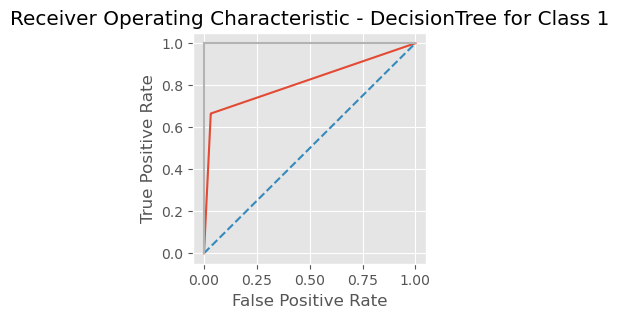

roc_auc_score for DecisionTree for Class 2 vs Rest:  0.7307165709575155


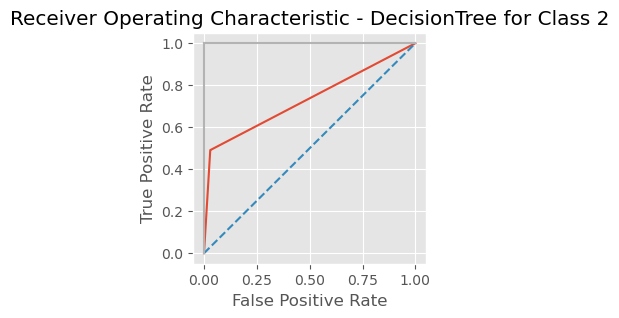

roc_auc_score for DecisionTree for Class 3 vs Rest:  0.7199314824885052


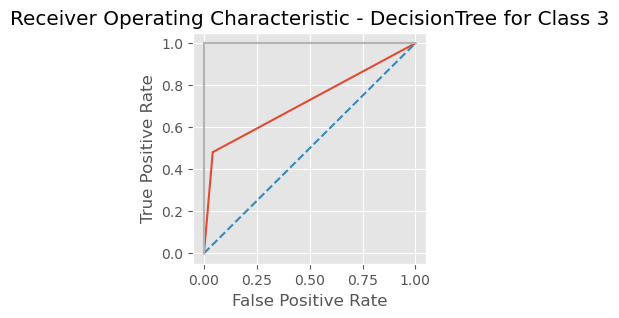

roc_auc_score for DecisionTree for Class 4 vs Rest:  0.7028734988874121


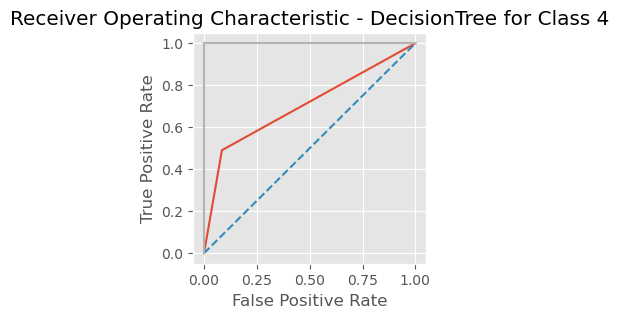

roc_auc_score for DecisionTree for Class 4 vs Rest:  0.8069518158922084


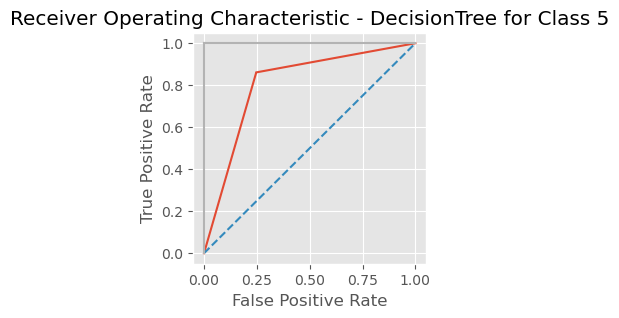

In [157]:
print("Accuracy:",accuracy_score(y_testr, y_predr))

from sklearn.metrics import classification_report
target_names = [ '1', '2', '3','4','5']
print(classification_report(y_testr, y_predr, target_names=target_names))
from sklearn.metrics import f1_score
print("F1 Score Macro:",f1_score(y_testr, y_predr, average='macro'))
print("F1 Score micro:",f1_score(y_testr, y_predr, average='micro'))
print("F1 Score weighted:",f1_score(y_testr, y_predr, average='weighted'))

from sklearn.metrics import roc_curve, roc_auc_score
y_testr1 = np.array(y_testr["Score"])
y_testr1 = [1 if y == 1 else 0 for y in y_testr1]
y_scorer1 = clfr.predict_proba(X_testr)[:,0]                 
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_testr1, y_scorer1)
print('roc_auc_score for DecisionTree for Class 1 vs Rest: ', roc_auc_score(y_testr1, y_scorer1))

plt.subplots(1, figsize=(3,3))
plt.title('Receiver Operating Characteristic - DecisionTree for Class 1')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##############################################END##################################################
y_testr2 = np.array(y_testr["Score"])
y_testr2 = [1 if y == 2 else 0 for y in y_testr2]
y_scorer2 = clfr.predict_proba(X_testr)[:,1]                 
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_testr2, y_scorer2)
print('roc_auc_score for DecisionTree for Class 2 vs Rest: ', roc_auc_score(y_testr2, y_scorer2))

plt.subplots(1, figsize=(3,3))
plt.title('Receiver Operating Characteristic - DecisionTree for Class 2')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
###############################################END#################################################

y_testr3 = np.array(y_testr["Score"])
y_testr3 = [1 if y == 3 else 0 for y in y_testr3]
y_scorer3 = clfr.predict_proba(X_testr)[:,2]                 
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_testr3, y_scorer3)
print('roc_auc_score for DecisionTree for Class 3 vs Rest: ', roc_auc_score(y_testr3, y_scorer3))

plt.subplots(1, figsize=(3,3))
plt.title('Receiver Operating Characteristic - DecisionTree for Class 3')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
#######################################END##############################################################
y_testr4 = np.array(y_testr["Score"])
y_testr4 = [1 if y == 4 else 0 for y in y_testr4]
y_scorer4 = clfr.predict_proba(X_testr)[:,3]                 
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_testr4, y_scorer4)
print('roc_auc_score for DecisionTree for Class 4 vs Rest: ', roc_auc_score(y_testr4, y_scorer4))

plt.subplots(1, figsize=(3,3))
plt.title('Receiver Operating Characteristic - DecisionTree for Class 4')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#################################END###############################################################
y_testr5 = np.array(y_testv["Score"])
y_testr5 = [1 if y == 5 else 0 for y in y_testr5]
y_scorer5 = clfr.predict_proba(X_testr)[:,4]                 
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_testr5, y_scorer5)
print('roc_auc_score for DecisionTree for Class 5 vs Rest: ', roc_auc_score(y_testr5, y_scorer5))

plt.subplots(1, figsize=(3,3))
plt.title('Receiver Operating Characteristic - DecisionTree for Class 5')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [158]:
reg = DecisionTreeRegressor()

regv = reg.fit(X_trainv, y_trainv)

y_predv = regv.predict(X_testv)

rmse = np.sqrt(MSE(y_testv, y_predv))
print("RMSE : % f" %(rmse))

print(r2_score(y_testv, y_predv))

RMSE :  1.150159
0.22849738899561678


In [159]:
regr = reg.fit(X_trainr, y_trainr)

y_predr = regr.predict(X_testr)

rmse = np.sqrt(MSE(y_testr, y_predr))
print("RMSE : % f" %(rmse))

print(r2_score(y_testr, y_predr))

RMSE :  0.909140
0.5179594999829585


In [160]:
print(scores(Text1, clfv, sia))
print(scores(Text1, regv, sia))
print(scores_r(Text1, model, clfr,tokenizer))
print(scores_r(Text1, model, regr,tokenizer))


print(scores(Text2, clfv, sia))
print(scores(Text2, regv, sia))
print(scores_r(Text2, model,clfr, tokenizer))
print(scores_r(Text2,model, regr,tokenizer))


print(scores(Text3, clfv, sia))
print(scores(Text3, regv, sia))
print(scores_r(Text3, model, clfr, tokenizer))
print(scores_r(Text3, model, regr, tokenizer))


4
5.0


/Users/shreyashdhumale/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- neg
- neu
- pos
Feature names seen at fit time, yet now missing:
- vader_neg
- vader_neu
- vader_pos

  warnings.warn(message, FutureWarning)
/Users/shreyashdhumale/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- neg
- neu
- pos
Feature names seen at fit time, yet now missing:
- roberta_neg
- roberta_neu
- roberta_pos

  warnings.warn(message, FutureWarning)
/Users/shreyashdhumale/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be rais

5
5.0
1
5.0
2
2.0
1
1.0
1
1.0


/Users/shreyashdhumale/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- neg
- neu
- pos
Feature names seen at fit time, yet now missing:
- roberta_neg
- roberta_neu
- roberta_pos

  warnings.warn(message, FutureWarning)
/Users/shreyashdhumale/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- neg
- neu
- pos
Feature names seen at fit time, yet now missing:
- roberta_neg
- roberta_neu
- roberta_pos

  warnings.warn(message, FutureWarning)


### Random Forest

In [161]:
#conda install python-graphviz

In [162]:
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz as gv

In [163]:
rf_cl = RandomForestClassifier()

rfv = rf_cl.fit(X_trainv, y_trainv)

y_predv = rfv.predict(X_testv)

print("Accuracy:",accuracy_score(y_testv, y_predv))
from sklearn.metrics import classification_report
target_names = [ '1', '2', '3','4','5']
print(classification_report(y_testv, y_predv, target_names=target_names))



/var/folders/qc/hkffj6qx3jl2g19d78lxb3440000gn/T/ipykernel_95647/2773232635.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfv = rf_cl.fit(X_trainv, y_trainv)


Accuracy: 0.680202684683083
              precision    recall  f1-score   support

           1       0.52      0.45      0.48     15498
           2       0.43      0.26      0.32      8803
           3       0.43      0.23      0.30     12517
           4       0.44      0.21      0.28     23998
           5       0.74      0.90      0.81    107919

    accuracy                           0.68    168735
   macro avg       0.51      0.41      0.44    168735
weighted avg       0.64      0.68      0.64    168735



roc_auc_score for DecisionTree for Class 1 vs Rest:  0.8330449828730747


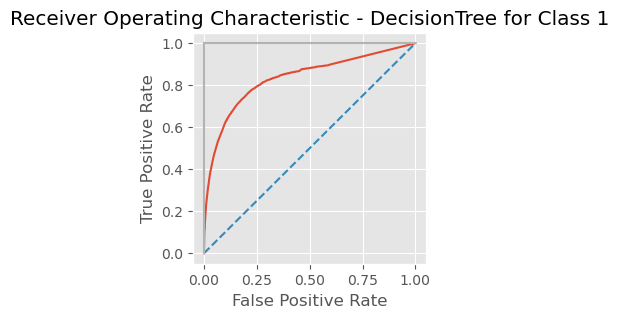

roc_auc_score for DecisionTree for Class 2 vs Rest:  0.7489681566898125


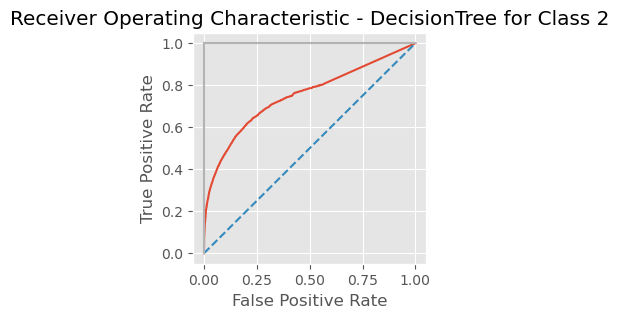

roc_auc_score for DecisionTree for Class 3 vs Rest:  0.7073642660765826


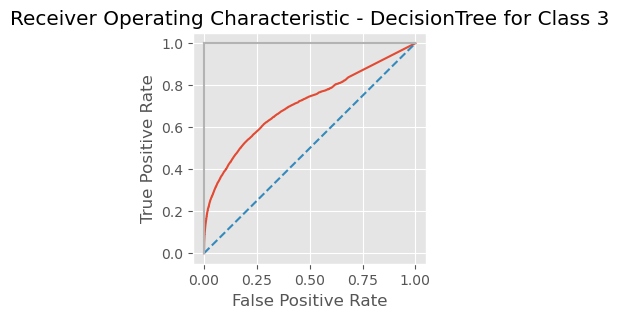

roc_auc_score for DecisionTree for Class 4 vs Rest:  0.6658552163501436


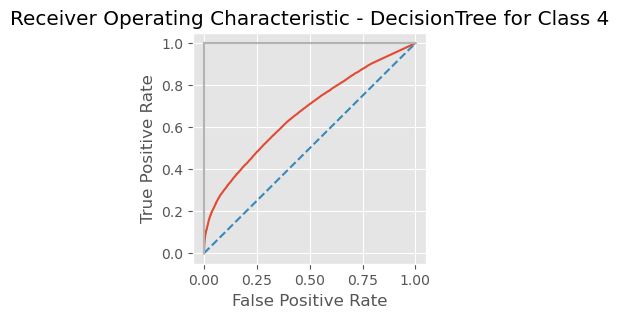

roc_auc_score for DecisionTree for Class 4 vs Rest:  0.7660982755894813


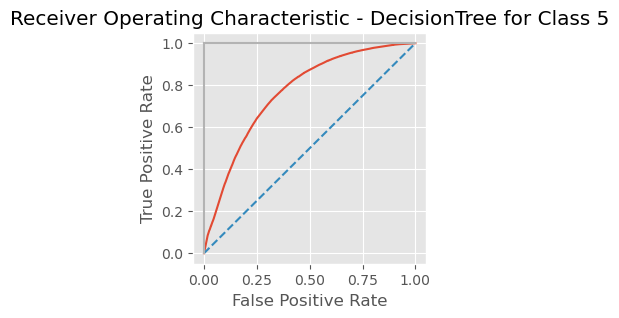

In [165]:
from sklearn.metrics import roc_curve, roc_auc_score
y_testv1 = np.array(y_testv["Score"])
y_testv1 = [1 if y == 1 else 0 for y in y_testv1]
y_scorev1 = rfv.predict_proba(X_testv)[:,0]                 
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_testv1, y_scorev1)
print('roc_auc_score for DecisionTree for Class 1 vs Rest: ', roc_auc_score(y_testv1, y_scorev1))

plt.subplots(1, figsize=(3,3))
plt.title('Receiver Operating Characteristic - DecisionTree for Class 1')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##############################################END##################################################
y_testv2 = np.array(y_testv["Score"])
y_testv2 = [1 if y == 2 else 0 for y in y_testv2]
y_scorev2 = rfv.predict_proba(X_testv)[:,1]                 
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_testv2, y_scorev2)
print('roc_auc_score for DecisionTree for Class 2 vs Rest: ', roc_auc_score(y_testv2, y_scorev2))

plt.subplots(1, figsize=(3,3))
plt.title('Receiver Operating Characteristic - DecisionTree for Class 2')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
###############################################END#################################################

y_testv3 = np.array(y_testv["Score"])
y_testv3 = [1 if y == 3 else 0 for y in y_testv3]
y_scorev3 = rfv.predict_proba(X_testv)[:,2]                 
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_testv3, y_scorev3)
print('roc_auc_score for DecisionTree for Class 3 vs Rest: ', roc_auc_score(y_testv3, y_scorev3))

plt.subplots(1, figsize=(3,3))
plt.title('Receiver Operating Characteristic - DecisionTree for Class 3')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
#######################################END##############################################################
y_testv4 = np.array(y_testv["Score"])
y_testv4 = [1 if y == 4 else 0 for y in y_testv4]
y_scorev4 = rfv.predict_proba(X_testv)[:,3]                 
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_testv4, y_scorev4)
print('roc_auc_score for DecisionTree for Class 4 vs Rest: ', roc_auc_score(y_testv4, y_scorev4))

plt.subplots(1, figsize=(3,3))
plt.title('Receiver Operating Characteristic - DecisionTree for Class 4')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#################################END###############################################################
y_testv5 = np.array(y_testv["Score"])
y_testv5 = [1 if y == 5 else 0 for y in y_testv5]
y_scorev5 = rfv.predict_proba(X_testv)[:,4]                 
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_testv5, y_scorev5)
print('roc_auc_score for DecisionTree for Class 5 vs Rest: ', roc_auc_score(y_testv5, y_scorev5))

plt.subplots(1, figsize=(3,3))
plt.title('Receiver Operating Characteristic - DecisionTree for Class 5')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [71]:
rfr = rf_cl.fit(X_trainr, y_trainr)

y_predr = rfr.predict(X_testr)

print("Accuracy:",accuracy_score(y_testr, y_predr))
from sklearn.metrics import classification_report
target_names = [ '1', '2', '3','4','5']
print(classification_report(y_testr, y_predr, target_names=target_names))

/var/folders/qc/hkffj6qx3jl2g19d78lxb3440000gn/T/ipykernel_95647/2466119196.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr = rf_cl.fit(X_trainr, y_trainr)


Accuracy: 0.7850179275194832
              precision    recall  f1-score   support

           1       0.69      0.74      0.71     15498
           2       0.56      0.46      0.51      8803
           3       0.57      0.47      0.51     12517
           4       0.64      0.44      0.52     23998
           5       0.85      0.93      0.89    107919

    accuracy                           0.79    168735
   macro avg       0.66      0.61      0.63    168735
weighted avg       0.77      0.79      0.77    168735



roc_auc_score for DecisionTree for Class 1 vs Rest:  0.958594877555894


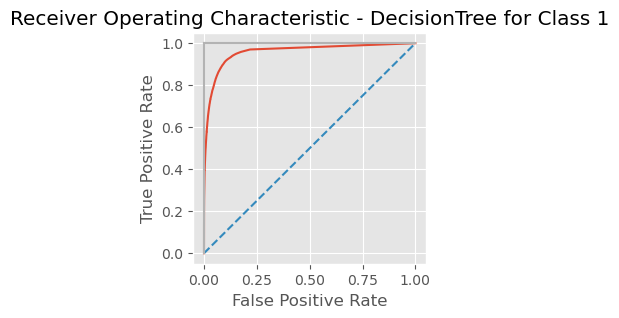

roc_auc_score for DecisionTree for Class 2 vs Rest:  0.9106543801506415


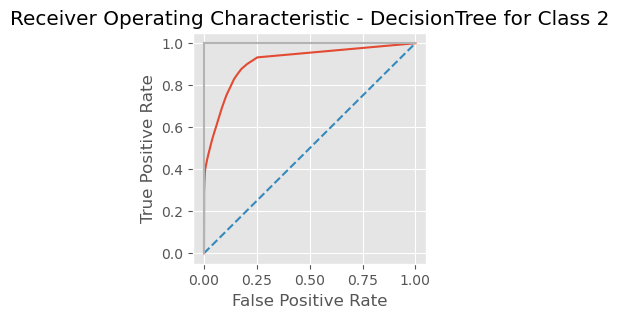

roc_auc_score for DecisionTree for Class 3 vs Rest:  0.8777227269521803


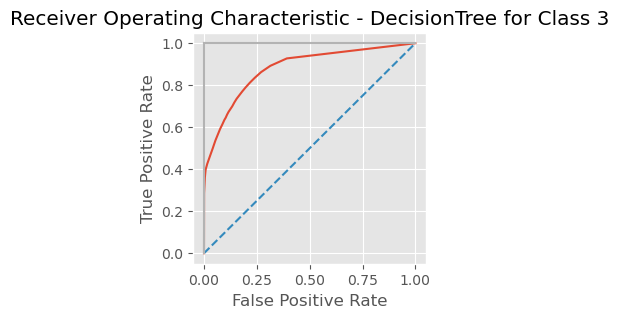

roc_auc_score for DecisionTree for Class 4 vs Rest:  0.8239772227622578


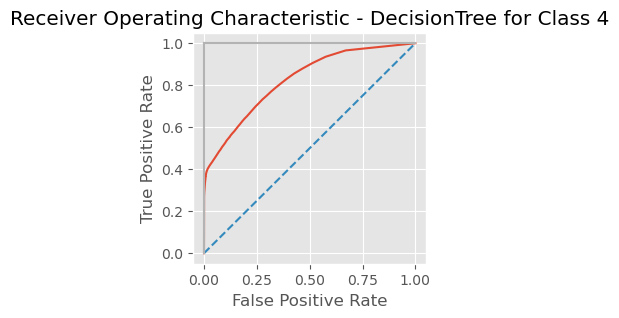

roc_auc_score for DecisionTree for Class 5 vs Rest:  0.9149322133211034


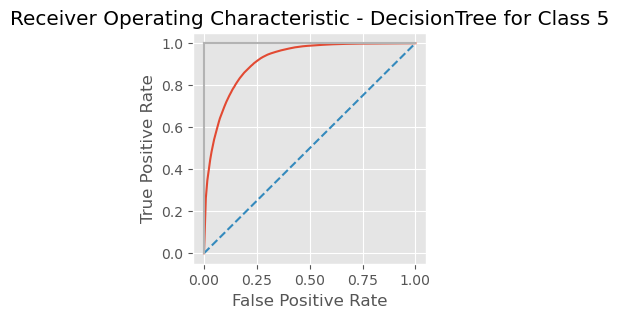

In [167]:
from sklearn.metrics import roc_curve, roc_auc_score
y_testr1 = np.array(y_testr["Score"])
y_testr1 = [1 if y == 1 else 0 for y in y_testr1]
y_scorer1 = rfr.predict_proba(X_testr)[:,0]                 
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_testr1, y_scorer1)
print('roc_auc_score for DecisionTree for Class 1 vs Rest: ', roc_auc_score(y_testr1, y_scorer1))

plt.subplots(1, figsize=(3,3))
plt.title('Receiver Operating Characteristic - DecisionTree for Class 1')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##############################################END##################################################
y_testr2 = np.array(y_testr["Score"])
y_testr2 = [1 if y == 2 else 0 for y in y_testr2]
y_scorer2 = rfr.predict_proba(X_testr)[:,1]                 
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_testr2, y_scorer2)
print('roc_auc_score for DecisionTree for Class 2 vs Rest: ', roc_auc_score(y_testr2, y_scorer2))

plt.subplots(1, figsize=(3,3))
plt.title('Receiver Operating Characteristic - DecisionTree for Class 2')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
###############################################END#################################################

y_testr3 = np.array(y_testr["Score"])
y_testr3 = [1 if y == 3 else 0 for y in y_testr3]
y_scorer3 = rfr.predict_proba(X_testr)[:,2]                 
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_testr3, y_scorer3)
print('roc_auc_score for DecisionTree for Class 3 vs Rest: ', roc_auc_score(y_testr3, y_scorer3))

plt.subplots(1, figsize=(3,3))
plt.title('Receiver Operating Characteristic - DecisionTree for Class 3')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
#######################################END##############################################################
y_testr4 = np.array(y_testr["Score"])
y_testr4 = [1 if y == 4 else 0 for y in y_testr4]
y_scorer4 = rfr.predict_proba(X_testr)[:,3]                 
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_testr4, y_scorer4)
print('roc_auc_score for DecisionTree for Class 4 vs Rest: ', roc_auc_score(y_testr4, y_scorer4))

plt.subplots(1, figsize=(3,3))
plt.title('Receiver Operating Characteristic - DecisionTree for Class 4')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#################################END###############################################################
y_testr5 = np.array(y_testv["Score"])
y_testr5 = [1 if y == 5 else 0 for y in y_testr5]
y_scorer5 = rfr.predict_proba(X_testr)[:,4]                 
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_testr5, y_scorer5)
print('roc_auc_score for DecisionTree for Class 5 vs Rest: ', roc_auc_score(y_testr5, y_scorer5))

plt.subplots(1, figsize=(3,3))
plt.title('Receiver Operating Characteristic - DecisionTree for Class 5')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [47]:
#regressor = RandomForestRegressor(n_estimators=100, random_state=0)
rf_reg = RandomForestRegressor()

rf_regv = rf_reg.fit(X_trainv, y_trainv)

y_predv = rf_regv.predict(X_testv)

rmse = np.sqrt(MSE(y_testv, y_predv))
print("RMSE : % f" %(rmse))

print(r2_score(y_testv, y_predv))

/var/folders/qc/hkffj6qx3jl2g19d78lxb3440000gn/T/ipykernel_95647/3189448900.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regv = rf_reg.fit(X_trainv, y_trainv)


RMSE :  1.091977
0.30457660805402453


In [48]:
rf_regr = rf_reg.fit(X_trainr, y_trainr)

y_predr = rf_regr.predict(X_testr)

rmse = np.sqrt(MSE(y_testr, y_predr))
print("RMSE : % f" %(rmse))

print(r2_score(y_testr, y_predr))

/var/folders/qc/hkffj6qx3jl2g19d78lxb3440000gn/T/ipykernel_95647/565203160.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regr = rf_reg.fit(X_trainr, y_trainr)


RMSE :  0.703227
0.711588071096552


In [49]:
print(scores(Text1, rfv, sia))
print(scores(Text1, rf_regv, sia))
print(scores_r(Text1, model, rfr,tokenizer))
print(scores_r(Text1, model, rf_regr,tokenizer))


print(scores(Text2, rfv, sia))
print(scores(Text2, rf_regv, sia))
print(scores_r(Text2, model,rfr, tokenizer))
print(scores_r(Text2,model, rf_regr,tokenizer))


print(scores(Text3, rfv, sia))
print(scores(Text3, rf_regv, sia))
print(scores_r(Text3, model, rfr, tokenizer))
print(scores_r(Text3, model, rf_regr, tokenizer))

5
4.34


/Users/shreyashdhumale/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- neg
- neu
- pos
Feature names seen at fit time, yet now missing:
- roberta_neg
- roberta_neu
- roberta_pos

  warnings.warn(message, FutureWarning)
/Users/shreyashdhumale/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- neg
- neu
- pos
Feature names seen at fit time, yet now missing:
- roberta_neg
- roberta_neu
- roberta_pos

  warnings.warn(message, FutureWarning)
/Users/shreyashdhumale/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will b

5
4.97
5
3.39
2


/Users/shreyashdhumale/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- neg
- neu
- pos
Feature names seen at fit time, yet now missing:
- roberta_neg
- roberta_neu
- roberta_pos

  warnings.warn(message, FutureWarning)
/Users/shreyashdhumale/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- neg
- neu
- pos
Feature names seen at fit time, yet now missing:
- roberta_neg
- roberta_neu
- roberta_pos

  warnings.warn(message, FutureWarning)
/Users/shreyashdhumale/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will b

2.2
1
1.6
1
1.04


/Users/shreyashdhumale/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- neg
- neu
- pos
Feature names seen at fit time, yet now missing:
- roberta_neg
- roberta_neu
- roberta_pos

  warnings.warn(message, FutureWarning)


### XG Boost

In [50]:
#import sys
#!{sys.executable} -m pip install xgboost

In [51]:
import pandas as pd
import numpy as np
import xgboost as xg
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

In [52]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_trainv_xg = le.fit_transform(y_trainv)
y_trainr_xg = le.fit_transform(y_trainr)

y_testv_xg = le.fit_transform(y_testv)
y_testr_xg = le.fit_transform(y_testr)

/Users/shreyashdhumale/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [53]:
xgb_cl = XGBClassifier()

xgbv = xgb_cl.fit(X_trainv, y_trainv_xg)

y_predv = xgbv.predict(X_testv)

print("Accuracy:",accuracy_score(y_testv_xg, y_predv))

Accuracy: 0.6610187572228643


In [54]:
xgbr = xgb_cl.fit(X_trainr, y_trainr_xg)

y_predr = xgbr.predict(X_testr)

print("Accuracy:",accuracy_score(y_testr_xg, y_predr))

Accuracy: 0.7106409458618543


In [55]:
#xgb_r = xg.XGBRegressor(objective ='reg:linear')
xgb_r = xg.XGBRegressor()

xgb_rv = xgb_r.fit(X_trainv, y_trainv)
  
# Predict the model
y_predv = xgb_rv.predict(X_testv)
  
# RMSE Computation
rmse = np.sqrt(MSE(y_testv, y_predv))
print("RMSE : % f" %(rmse))

print(r2_score(y_testv, y_predv))

RMSE :  1.103039
0.29041656290490037


In [56]:
xgb_rr = xgb_r.fit(X_trainr, y_trainr)
  
# Predict the model
y_predr = xgb_rr.predict(X_testr)
  
# RMSE Computation
rmse = np.sqrt(MSE(y_testr, y_predr))
print("RMSE : % f" %(rmse))

print(r2_score(y_testr, y_predr))

RMSE :  0.796840
0.6296907920699144


In [57]:
print(scores(Text1, xgbv, sia))
print(scores(Text1, xgb_rv, sia))
print(scores_r(Text1, model, xgbr,tokenizer))
print(scores_r(Text1, model, xgb_rr,tokenizer))


print(scores(Text2, xgbv, sia))
print(scores(Text2, xgb_rv, sia))
print(scores_r(Text2, model,xgbr, tokenizer))
print(scores_r(Text2,model, xgb_rr,tokenizer))


print(scores(Text3, xgbv, sia))
print(scores(Text3, xgb_rv, sia))
print(scores_r(Text3, model, xgbr, tokenizer))
print(scores_r(Text3, model, xgb_rr, tokenizer))

ValueError: feature_names mismatch: ['roberta_neg', 'roberta_neu', 'roberta_pos'] ['neg', 'neu', 'pos']
expected roberta_pos, roberta_neu, roberta_neg in input data
training data did not have the following fields: neu, neg, pos

# Step 4: Review Examples:

- Positive 1-Star and Negative 5-Star Reviews

Lets look at some examples where the model scoring and review score differ the most.

In [ ]:
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

In [ ]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

In [ ]:
# nevative sentiment 5-Star view

In [ ]:
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

In [ ]:
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

# Extra: The Transformers Pipeline
- Quick & easy way to run sentiment predictions

In [ ]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

In [ ]:
sent_pipeline('I love sentiment analysis!')

In [ ]:
sent_pipeline('Make sure to like and subscribe!')

In [ ]:
sent_pipeline('booo')

# The End